In [283]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from sklearn.preprocessing import StandardScaler

In [284]:
def moving_avg(x, N=1000):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

Initializing variables and reading datasets

In [285]:
dsets = []
accelpedal = []
driverdem = []
engtorque = []
path = r'Final_engine_sys_data'

In [286]:
for i in range(32):
    dsets.append(pd.read_csv(path + '\\final_engine_dset_' + str(i)+'.csv'))            #Moving averages are taken to smoothen the data
    #vals = moving_avg(dsets[i]['61443-91'][::500], 500)
    accelpedal.append(dsets[i]['61443-91'][::500])
    vals = moving_avg(dsets[i]['61444-512'], 1000)
    driverdem.append(vals[::250])
    vals = moving_avg(dsets[i]['61444-513'], 50000)
    engtorque.append(vals[::250])

for i in range(6):
    dsets.append(pd.read_csv(path + '\\faulty_engine_dset_' + str(i)+'.csv'))
    #vals = moving_avg(dsets[32+i]['61443-91'], 500)                           #fix this
    #accelpedal.append(vals[::250])
    accelpedal.append(dsets[32+i]['61443-91'][::500])
    vals = moving_avg(dsets[32+i]['61444-512'], 1000)
    driverdem.append(vals[::250])
    vals = moving_avg(dsets[32+i]['61444-513'], 50000)
    engtorque.append(vals[::250])

Reshape and format the datasets to be timeseries

In [287]:
formatted_pedal = to_time_series_dataset(accelpedal)
formatted_demand = to_time_series_dataset(driverdem)
formatted_torque = to_time_series_dataset(engtorque)
print("Accelerator Pedal Position Shape: " + str(formatted_pedal.shape))
print("Driver\'s Demand Torque Shape: " + str(formatted_demand.shape))
print("Actual Engine Torque Shape: " + str(formatted_torque.shape))

Accelerator Pedal Position Shape: (38, 254, 1)
Driver's Demand Torque Shape: (38, 503, 1)
Actual Engine Torque Shape: (38, 307, 1)


Plotting the timeseries

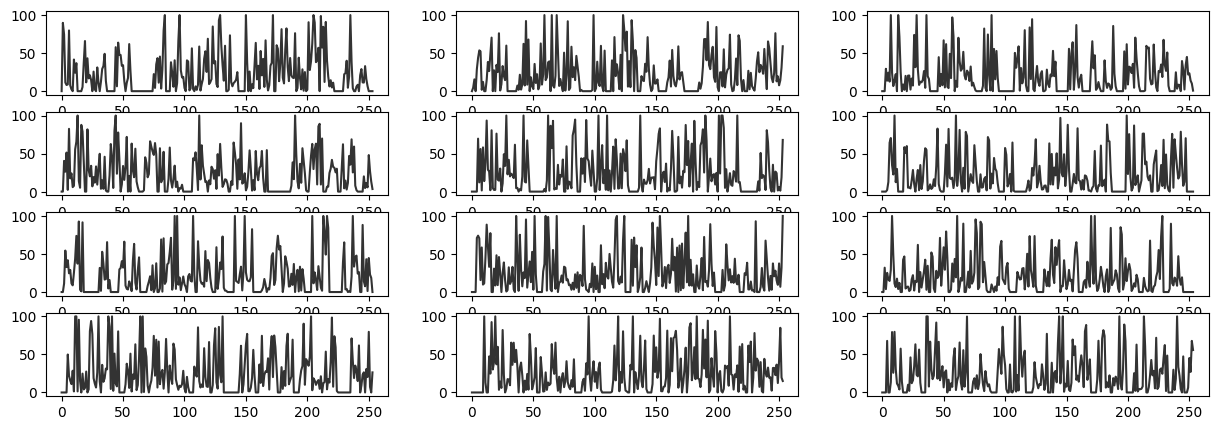

In [288]:
#Normal Accel Pedal
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_pedal[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

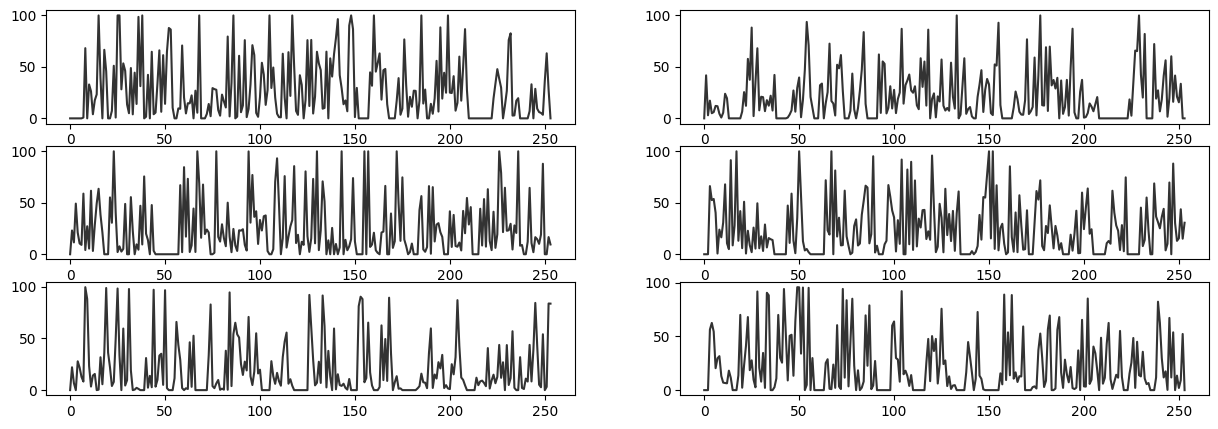

In [289]:
#Some Accel Pedal with Faults 
plt.figure(figsize=(15,5))
for yi in range(6):
    plt.subplot(3, 2, yi + 1)
    plt.plot(formatted_pedal[32+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

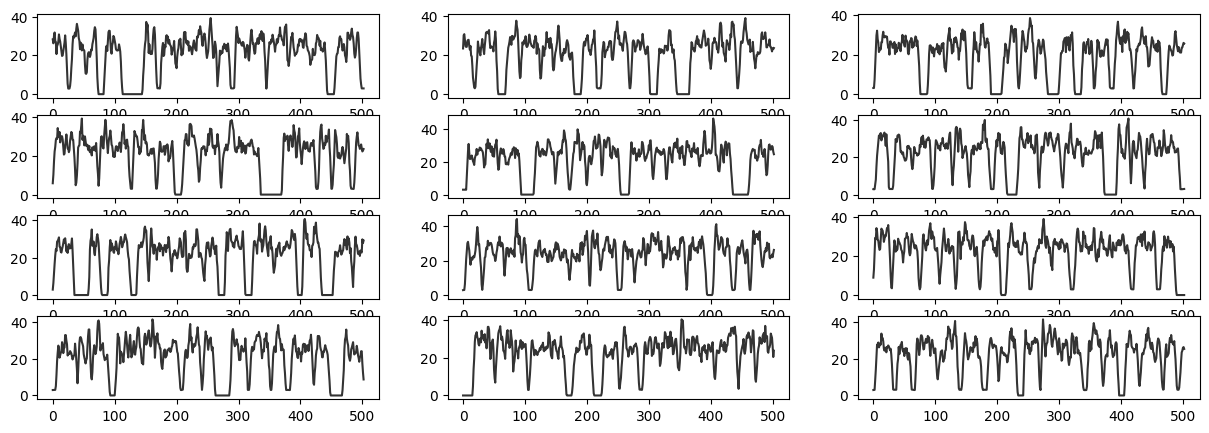

In [290]:
#Normal Driver's Demand
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_demand[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

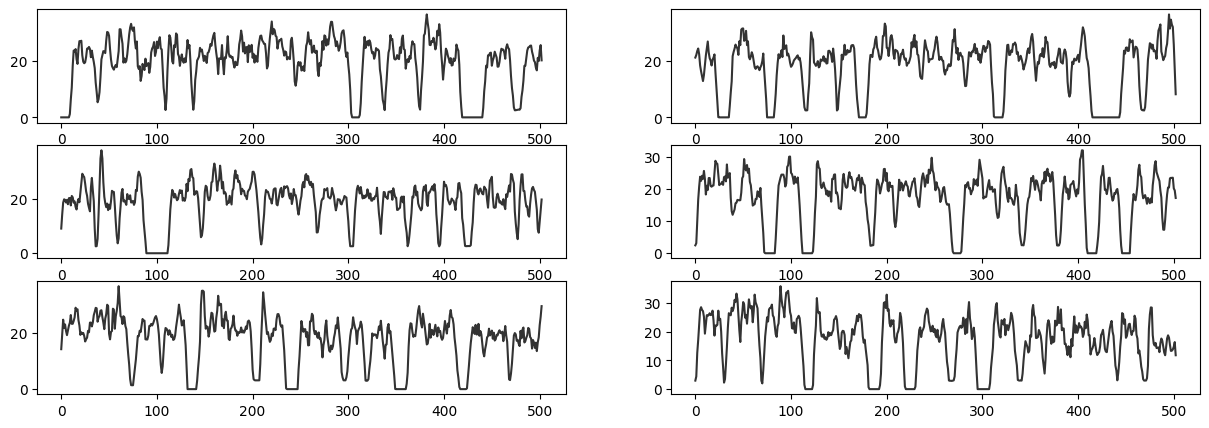

In [291]:
#Some Driver's Demand with Faults
plt.figure(figsize=(15,5))
for yi in range(6):
    plt.subplot(3, 2, yi + 1)
    plt.plot(formatted_demand[32+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

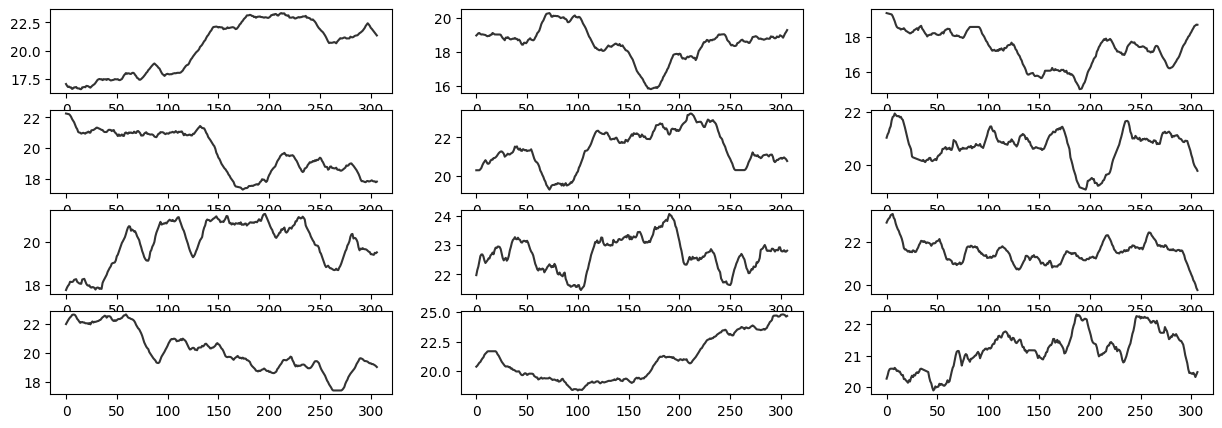

In [292]:
#Normal Actual Engine Torque
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_torque[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

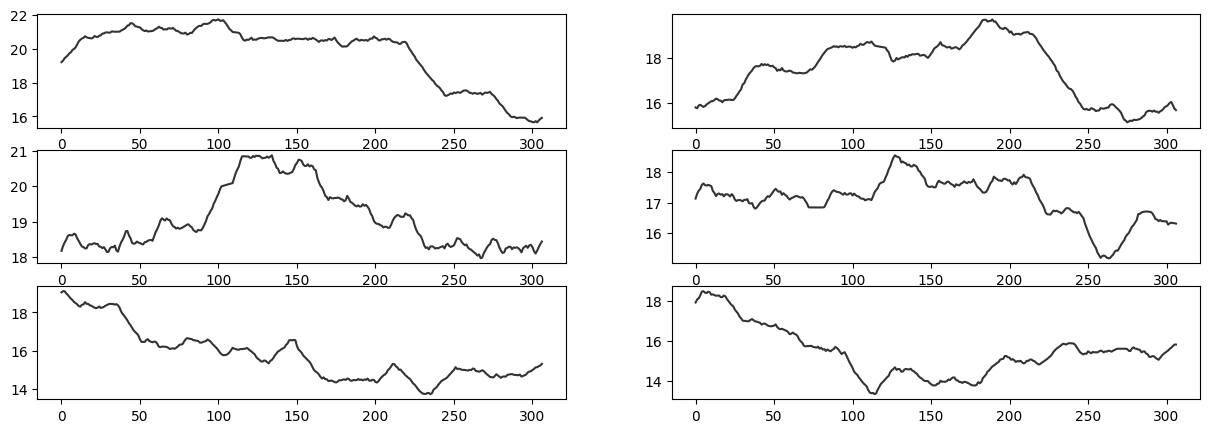

In [293]:
#Some Actual Engine with Faults 
plt.figure(figsize=(15,5))
for yi in range(6):
    plt.subplot(3, 2, yi + 1)
    plt.plot(formatted_torque[32+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

Checking Number of Clusters needed using the Elbow method and silhouette score

In [294]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=1,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_torque)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_torque)
    sil_score = silhouette_score(formatted_torque, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.38625162030952587
[126.5534330445564]
0.3464151256910661
[126.5534330445564, 72.70766138174474]
0.27905103084254285
[126.5534330445564, 72.70766138174474, 62.641777275451695]
0.32774532482805063
[126.5534330445564, 72.70766138174474, 62.641777275451695, 50.33448988496857]
0.315371519873634
[126.5534330445564, 72.70766138174474, 62.641777275451695, 50.33448988496857, 47.845812309027956]


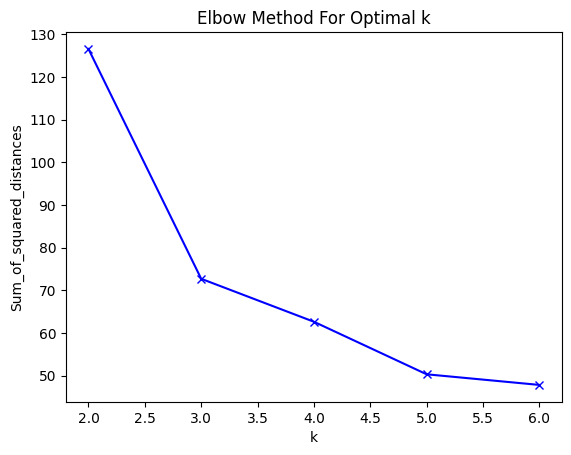

In [295]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering for engine torque using DTW

DBA k-means
DBA silhoutte: 0.35


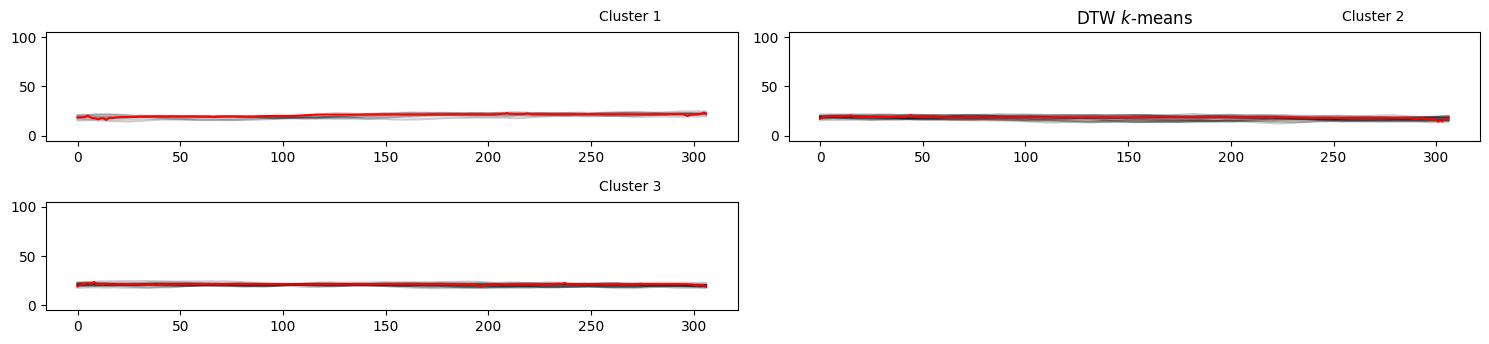

In [296]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_torque)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_torque, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_torque[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.ylim(-5, 105)
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        


plt.tight_layout()
plt.show()

Checking clusters for Driver's Demand

In [297]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=1,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_demand)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_demand)
    sil_score = silhouette_score(formatted_demand, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.03304509722970186
[3680.4819135416997]
0.03791243897087823
[3680.4819135416997, 3329.2392469702677]
0.010251595546864523
[3680.4819135416997, 3329.2392469702677, 3270.2568507722476]
0.04869046491709636
[3680.4819135416997, 3329.2392469702677, 3270.2568507722476, 2957.912109142509]
0.049517754060828444
[3680.4819135416997, 3329.2392469702677, 3270.2568507722476, 2957.912109142509, 2731.1170075919313]


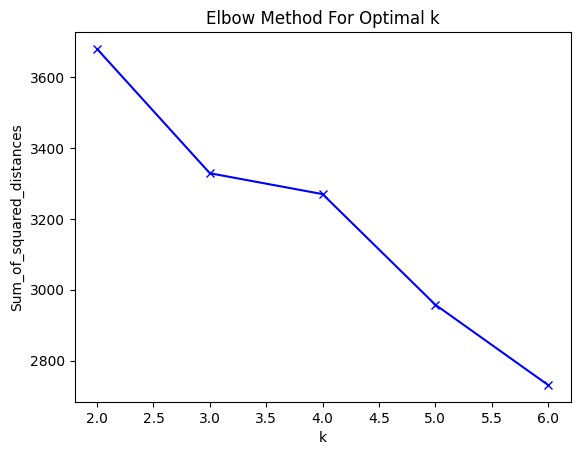

In [298]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering for Driver's Demand using DTW

DBA k-means
DBA silhoutte: 0.04


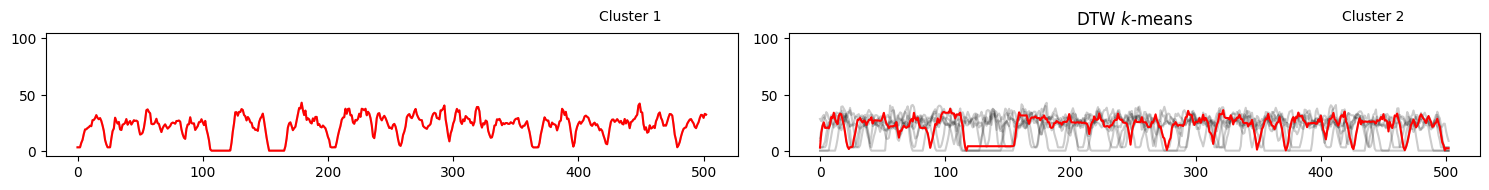

In [299]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_demand)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_demand, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(2):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_demand[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.ylim(-5, 105)
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        


plt.tight_layout()
plt.show()

Checking clusters for Accelerator Pedal Position

In [300]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=1,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_pedal)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_pedal)
    sil_score = silhouette_score(formatted_pedal, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.03420680296127751
[41948.89958600302]
0.013976141777240594
[41948.89958600302, 39893.36646148356]
0.013550492532597401
[41948.89958600302, 39893.36646148356, 38543.10242816425]
0.011856903871843724
[41948.89958600302, 39893.36646148356, 38543.10242816425, 36924.87525753244]
0.004293226650588333
[41948.89958600302, 39893.36646148356, 38543.10242816425, 36924.87525753244, 35443.756813458196]


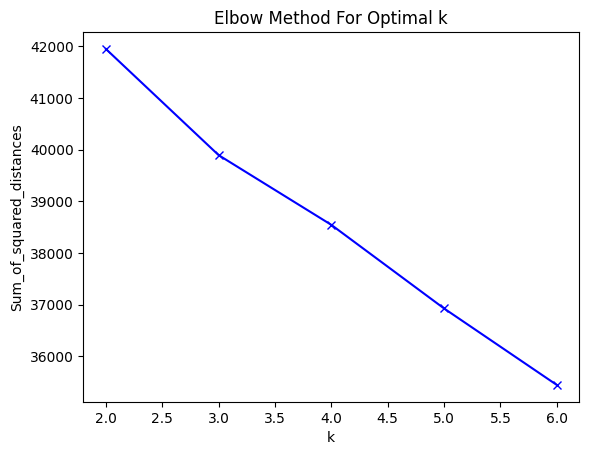

In [301]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering for accelerator pedal position using DTW

DBA k-means
DBA silhoutte: 0.03


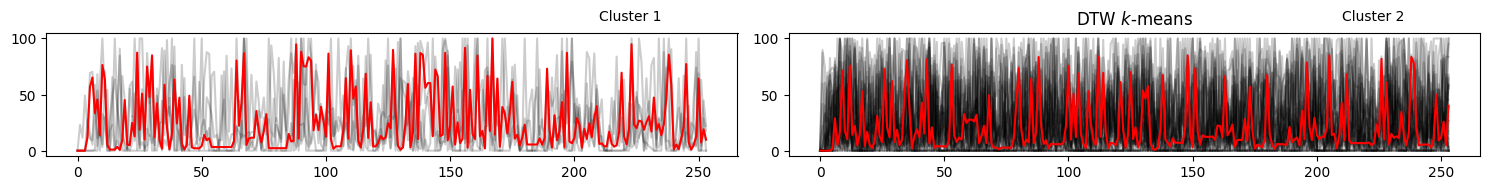

In [302]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=1,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_pedal)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_pedal, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(2):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_pedal[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.ylim(-5, 105)
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        


plt.tight_layout()
plt.show()